
# Car Body Type Classification - Classical Machine Learning
# Dataset: Pre-split into train/val/test folders
# Features: HOG (shape) + HSV histogram (color)


## 1️ Import Libraries

In [18]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

## 2 Feature Extraction Function

In [19]:
def extract_features(img_path):
    """
    Extract handcrafted features from an image:
    - HOG for shape/edges
    - HSV histogram for color
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))

    # ---- HOG (Shape features) ----
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True
    )

    # ---- HSV Color Histogram ----
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # ---- Combine features ----
    return np.hstack([hog_features, hist])


## 3 Load Dataset from Folders

In [20]:
def load_dataset(folder_path):
    """
    Loads images and extracts features from a folder structure:
    folder_path/
        Class1/
            img1.jpg, img2.jpg...
        Class2/
            ...

    Args:
        folder_path (str): path to train/val/test folder

    Returns:
        X (np.array): feature vectors
        y (list): class labels (folder names)
    """
    X, y = [], []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            features = extract_features(img_path)
            X.append(features)
            y.append(class_name)

    return np.array(X), np.array(y)
# Paths to your dataset folders
train_dir = "dataset/train"
val_dir = "dataset/valid"
test_dir = "dataset/test"

# Load datasets
X_train, y_train = load_dataset(train_dir)
X_val, y_val = load_dataset(val_dir)
X_test, y_test = load_dataset(test_dir)

print("Dataset shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
print(np.unique(y_train))



Dataset shapes:
X_train: (5350, 2276) y_train: (5350,)
X_val: (1397, 2276) y_val: (1397,)
X_test: (802, 2276) y_test: (802,)
['Convertible' 'Coupe' 'Hatchback' 'Pick-Up' 'SUV' 'Sedan' 'VAN']


## 4 Encode Labels

In [21]:
# Convert class names to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

## 5 Shuflling Dataset

In [22]:
X_train, y_train_enc = shuffle(X_train, y_train_enc, random_state=42)
X_val, y_val_enc = shuffle(X_val, y_val_enc, random_state=42)
X_test, y_test_enc = shuffle(X_test, y_test_enc, random_state=42)

## 6 Feature Selection

In [23]:
# Remove near-constant features
var_thresh = VarianceThreshold(threshold=0.01)
X_train_sel = var_thresh.fit_transform(X_train)
X_val_sel   = var_thresh.transform(X_val)
X_test_sel  = var_thresh.transform(X_test)

# Select top-k features (safe k)
k = min(200, X_train_sel.shape[1])
k_best = SelectKBest(score_func=f_classif, k=k)

X_train_sel = k_best.fit_transform(X_train_sel, y_train_enc)
X_val_sel   = k_best.transform(X_val_sel)
X_test_sel  = k_best.transform(X_test_sel)

print("After selection:", X_train_sel.shape)


After selection: (5350, 200)


## 7 Feature Scaling

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_val_scaled = scaler.transform(X_val_sel)
X_test_scaled = scaler.transform(X_test_sel)

## 8 Dimensionality Reduction with PCA

In [25]:
pca = PCA(n_components=0.98, random_state=42)  # keep 98% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Feature dimensions after PCA:", X_train_pca.shape)

Feature dimensions after PCA: (5350, 110)


## 9 Train Classical ML Models

In [26]:
models = {
    "SVM": SVC(kernel='rbf'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(eval_metric='mlogloss',random_state=42)
}

best_model_name = ""
best_val_acc = 0
best_model = None

for name, model in models.items():
    # Train model on training set
    model.fit(X_train_pca, y_train_enc)
    # Validate on validation set
    y_val_pred = model.predict(X_val_pca)
    acc = accuracy_score(y_val_enc, y_val_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")

    # Keep track of the best model
    if acc > best_val_acc:
        best_val_acc = acc
        best_model = model
        best_model_name = name

print(f"\nBest model: {best_model_name} with validation accuracy {best_val_acc:.4f}")

SVM Validation Accuracy: 0.6850
RandomForest Validation Accuracy: 0.4789
KNN Validation Accuracy: 0.4868
XGBoost Validation Accuracy: 0.5505

Best model: SVM with validation accuracy 0.6850


## 10 SVM Hyperparameter Tuning

In [27]:
param_grid = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_pca, y_train_enc)

print("Best SVM Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

best_model = grid.best_estimator_


Best SVM Params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV Accuracy: 0.6521493686846457


## 11 Evaluate on Test Set


Test Accuracy: 0.7019950124688279

Classification Report:
              precision    recall  f1-score   support

 Convertible       0.76      0.80      0.78       174
       Coupe       0.51      0.56      0.53        79
   Hatchback       0.60      0.55      0.57        99
     Pick-Up       0.72      0.79      0.76       110
         SUV       0.67      0.61      0.64       125
       Sedan       0.64      0.62      0.63       109
         VAN       0.93      0.90      0.91       106

    accuracy                           0.70       802
   macro avg       0.69      0.69      0.69       802
weighted avg       0.70      0.70      0.70       802



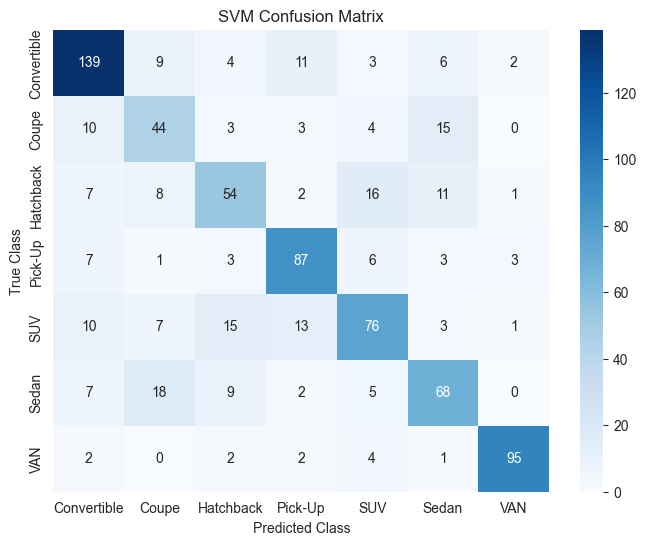

In [28]:
y_test_pred = best_model.predict(X_test_pca)
test_acc = accuracy_score(y_test_enc, y_test_pred)
print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title(f"{best_model_name} Confusion Matrix")
plt.show()